# Quality assessment of some real-world arterial pressure data

Data are used under the terms of the [VitalDB Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb). If you do not agree with this agreement, please close this file.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os, sys
sys.path.append(os.pardir)  # Needed for medical_waveforms import before we install it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from medical_waveforms.features import cycles
from medical_waveforms.waveforms import Waveforms
from medical_waveforms.features.waveform import find_troughs
from medical_waveforms.features.cycles import get_cycles
from medical_waveforms import quality
from medical_waveforms.utils import get_root_directory

## Load and visualise data

In [7]:
data_path = os.path.join(
    get_root_directory(), "local_data", "abp_waveform_extract_125hz.csv"
)

In [8]:
data = pd.read_csv(data_path, index_col=0)
data = data.rename({"Time": "time", "SNUADC/ART": "pressure"}, axis=1)
data.time -= data.time.values[0]

data.head()

,time,pressure
0,0.000,-0.910027
1,0.008,-0.910027
2,0.016,0.077430
3,0.024,-0.910027
4,0.032,-0.910027


In [9]:
data = data.loc[data.time < 1000]

## Load the data into medical-waveforms

In [10]:
wf = Waveforms(data)

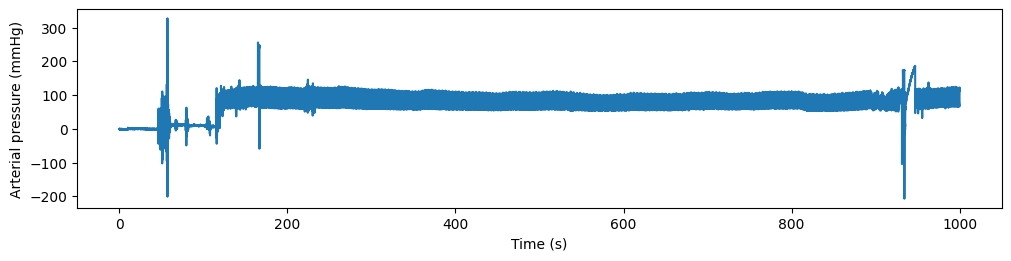

In [11]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

## Find troughs in the waveform

In [12]:
wf = find_troughs(wf, name='pressure', scale=70)

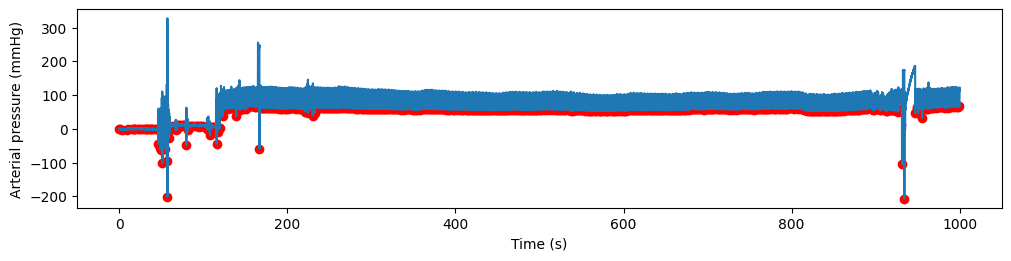

In [13]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.scatter(
    data.time[wf.features.waveform['pressure']['troughs']],
    data.pressure[wf.features.waveform['pressure']['troughs']],
    color='red',
)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

## Assess signal quality

Load some preset checks:

In [14]:
checks = quality.ArterialPressureChecks()
checks

ArterialPressureChecks(diastolic_pressure=CycleCheck(feature=<class 'medical_waveforms.features.cycles.MinimumValue'>, min=20.0, max=200.0, units='mmHg', description=None), systolic_pressure=CycleCheck(feature=<class 'medical_waveforms.features.cycles.MaximumValue'>, min=30.0, max=300.0, units='mmHg', description=None), mean_pressure=CycleCheck(feature=<class 'medical_waveforms.features.cycles.MeanValue'>, min=30.0, max=200.0, units='mmHg', description=None), heart_rate=CycleCheck(feature=<class 'medical_waveforms.features.cycles.CyclesPerMinute'>, min=20.0, max=200.0, units='beats per minute', description=None), pulse_pressure=CycleCheck(feature=<class 'medical_waveforms.features.cycles.MaximumMinusMinimumValue'>, min=20.0, max=250.0, units='mmHg', description=None), mean_dyneg=CycleCheck(feature=<class 'medical_waveforms.features.cycles.MeanNegativeFirstDifference'>, min=-3.0, max=0.0, units='mmHg', description=None), diastolic_pressure_diff=DiffCheck(feature=<class 'medical_waveform

Tweak the presets a little:

In [15]:
checks.diastolic_pressure.min = 30.0

Check each cycle:

In [16]:
check_results = quality.check_cycles(wf, "pressure", checks)
check_results.head()

,diastolic_pressure,systolic_pressure,mean_pressure,heart_rate,pulse_pressure,mean_dyneg,diastolic_pressure_diff,systolic_pressure_diff,beat_time_diff,all
0,False,False,False,True,False,True,True,True,True,False
1,False,False,False,True,False,True,True,True,False,False
2,False,False,False,False,False,True,True,True,False,False
3,False,False,False,True,False,True,True,True,False,False
4,False,False,False,False,False,True,True,True,False,False


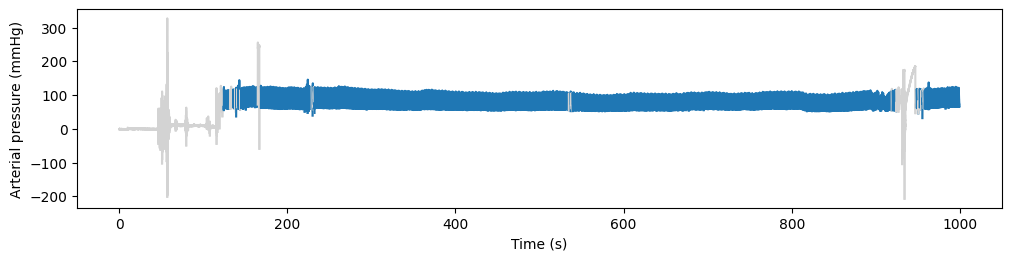

In [17]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)

for cycle_i, cycle in enumerate(get_cycles(wf, "pressure")):
    if check_results.loc[cycle_i, 'all'].squeeze():
        colour='tab:blue'
    else:
        colour='lightgray'
    ax.plot(cycle.time, cycle.pressure, c=colour)

ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

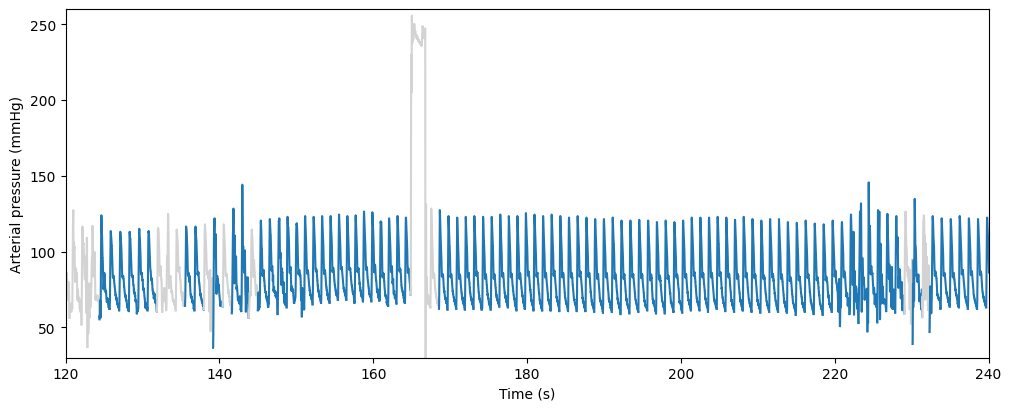

In [18]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

for cycle_i, cycle in enumerate(get_cycles(wf, "pressure")):
    if check_results.loc[cycle_i, 'all'].squeeze():
        colour='tab:blue'
    else:
        colour='lightgray'
    ax.plot(cycle.time, cycle.pressure, c=colour)

ax.set(
    xlabel='Time (s)',
    ylabel='Arterial pressure (mmHg)',
    xlim=(120, 240),
    ylim=(30, 260)
)
plt.show()

## Further check customisation

We can add extra checks of our own:

In [19]:
checks_with_extra_diff = quality.ArterialPressureChecks(
    map_diff=quality.DiffCheck(
        feature=cycles.MeanValue,
        threshold=15.0,
        units='mmHg'
    )
)

quality.check_cycles(wf, "pressure", checks_with_extra_diff).head()

,diastolic_pressure,systolic_pressure,mean_pressure,heart_rate,pulse_pressure,mean_dyneg,diastolic_pressure_diff,systolic_pressure_diff,beat_time_diff,map_diff,all
0,False,False,False,True,False,True,True,True,True,True,False
1,False,False,False,True,False,True,True,True,False,True,False
2,False,False,False,False,False,True,True,True,False,True,False
3,False,False,False,True,False,True,True,True,False,True,False
4,False,False,False,False,False,True,True,True,False,True,False


We can also remove unwanted checks easily:

In [20]:
checks_with_check_removed = quality.ArterialPressureChecks()
del checks_with_check_removed.heart_rate

quality.check_cycles(wf, "pressure", checks_with_check_removed).head()

,diastolic_pressure,systolic_pressure,mean_pressure,pulse_pressure,mean_dyneg,diastolic_pressure_diff,systolic_pressure_diff,beat_time_diff,all
0,False,False,False,False,True,True,True,True,False
1,False,False,False,False,True,True,True,False,False
2,False,False,False,False,True,True,True,False,False
3,False,False,False,False,True,True,True,False,False
4,False,False,False,False,True,True,True,False,False
